In [1]:
import csv
import sys
import pandas as pd
from numpy import nanmedian
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
metric_names = {
    'changes_size': 'Code churn',
    'test_changes_size': 'Test churn',
    'code_churn_overall': 'Prior changes',
    'LOC': 'LOC',
    'avg_cyclomatic': 'Average cyclomatic',
    'cnt_func': 'Number of functions',
    'maxnesting': 'Maximum nesting',
    'ratio_comment': 'Comment ratio',
    'modules_num': 'Module number',
    'page_rank': 'PageRank',
    'betweenness': 'Betweenness',
    'closeness': 'Closeness',
    'developer_familiarity_overall': 'Developer exp.',
    'reviewer_familiarity_overall': 'Reviewer exp.',
    'comments': '\\# of comments',
    'comment_words': 'Comment words',
    'review_duration': 'Review duration',
    'min_neg': 'Developer sentiment',
    'owner_neg': 'Owner sentiment',
    'landing_delta': 'Landing delta',
    'response_delta': 'Response delta',
    'release_delta': 'Release delta',
}

In [3]:
def loadMetrics():
    with open('../metric_list.txt') as f:
        return [line.rstrip('\n') for line in f]

In [4]:
def loadData():
    df_aurora = pd.read_csv('../independent_metrics/basic_aurora.csv')
    df_beta = pd.read_csv('../independent_metrics/basic_beta.csv')
    df_release = pd.read_csv('../independent_metrics/basic_release.csv')
    df_review = pd.read_csv('../independent_metrics/review_metrics.csv')
    df_src = pd.read_csv('../independent_metrics/src_code_metrics.csv')
    df_senti = pd.read_csv('../independent_metrics/senti_metrics.csv')
#    df_basic = pd.concat([df_aurora, df_beta, df_release]).drop_duplicates()
    df_basic = df_beta
    df = pd.merge(df_basic, df_review, on='bug_id')
    df = pd.merge(df, df_senti, on='bug_id')
    df = pd.merge(df, df_src, on='bug_id')
    # Convert deltas from seconds to days.
    df.landing_delta = df.landing_delta / 86400
    df.response_delta = df.response_delta / 86400
    df.release_delta = df.release_delta / 86400
    # Ignore uplifts in the 'Pocket' component.
    df = df[df.component != 'Pocket']
    return df

In [5]:
def subCategories(df, df_input, tag, value):
    df = pd.merge(df_input, df, on='bug_id')
    df_sub1 = df[df[tag] == value]
    df_sub2 = df[df[tag] != value]
    return df_sub1, df_sub2

In [6]:
def bonferroniCorrection(p_value, num_tests):
    if p_value * num_tests < 1:
        return p_value * num_tests
    return 1

In [18]:
def outputResults(df_sub1, df_sub2, cat1):
    output_list = list()
    metric_list = loadMetrics()
    for metric in metric_list:
        sub1_median = nanmedian(df_sub1[metric])
        sub2_median = nanmedian(df_sub2[metric])
        
        #print([df_sub1[metric], df_sub2[metric]])
        
        plt.boxplot([df_sub1[metric], df_sub2[metric]], showfliers=False)
        plt.title(metric_names[metric])
        plt.show()
        
        statistic,p_value = stats.mannwhitneyu(df_sub1[metric], df_sub2[metric])
        corrected_p = bonferroniCorrection(p_value, 22)
        
        output_list.append([metric_names[metric], sub1_median, sub2_median, corrected_p])
        
    print (pd.DataFrame(output_list, columns=['metric', cat1, 'others', 'p-value']).round(2))
    return

In [19]:
df = loadData()

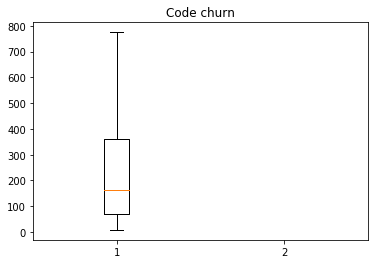

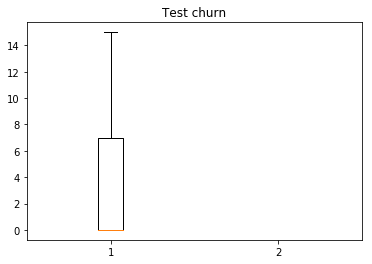

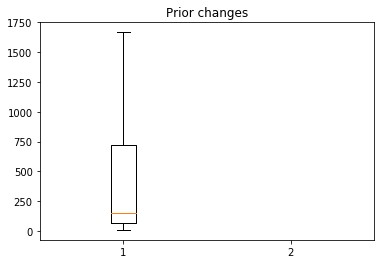

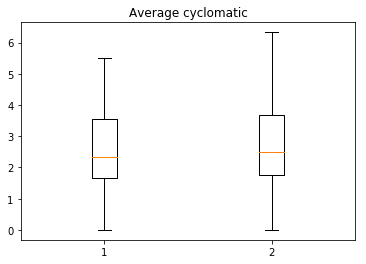

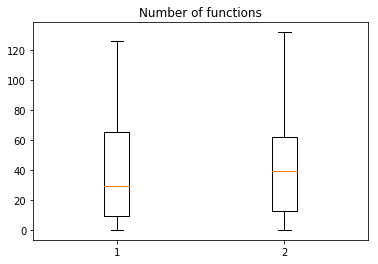

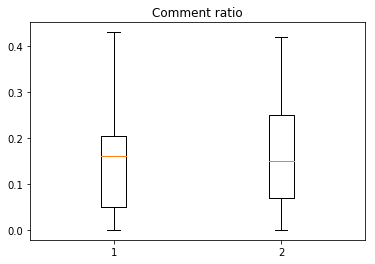

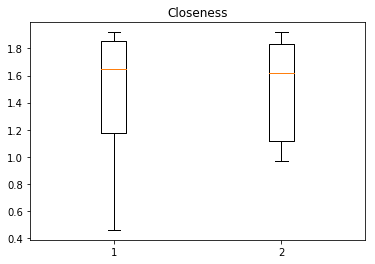

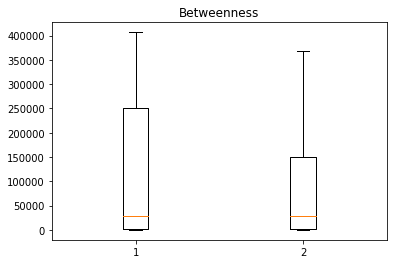

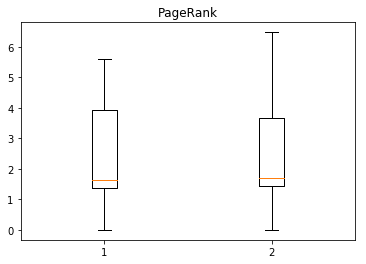

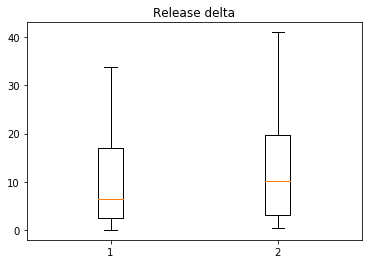

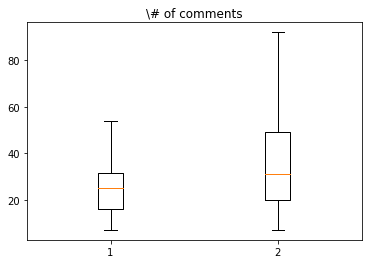

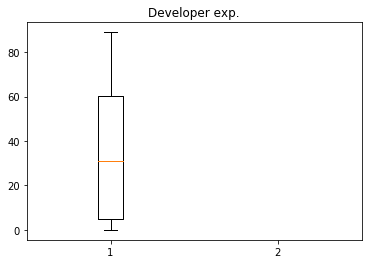

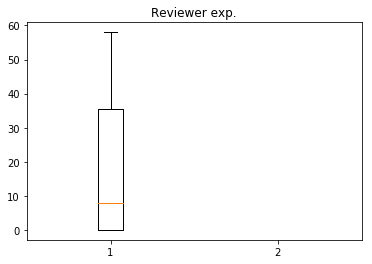

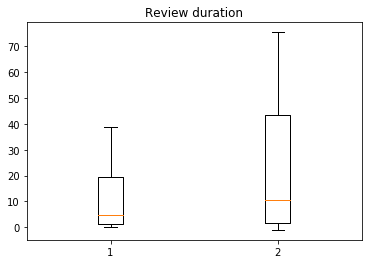

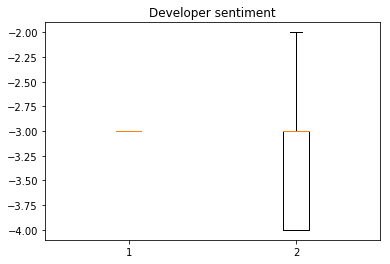

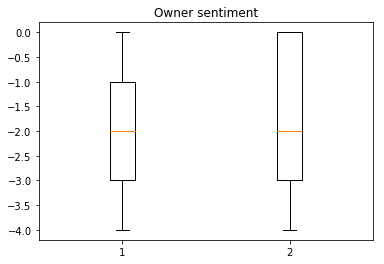

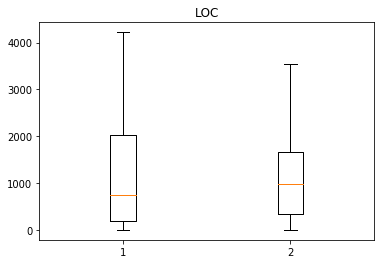

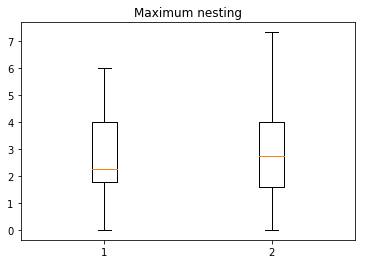

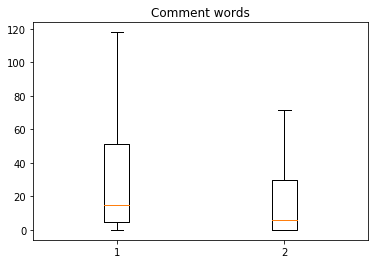

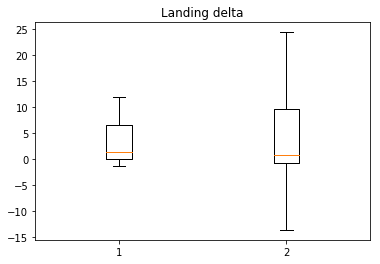

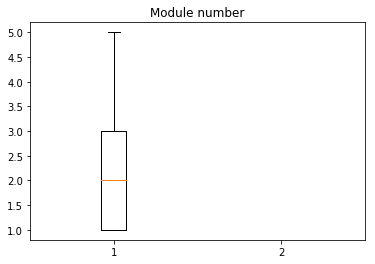

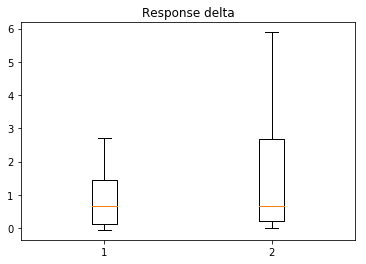

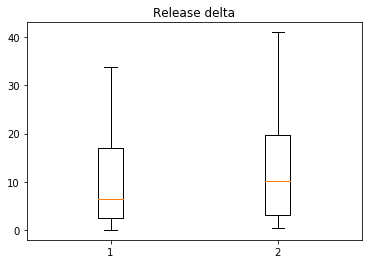

                 metric  more severe    others  p-value
0            Code churn       161.00    118.50     1.00
1            Test churn         0.00      0.00     1.00
2         Prior changes       150.00    202.50     1.00
3    Average cyclomatic         2.33      2.50     1.00
4   Number of functions        29.44     39.13     1.00
5         Comment ratio         0.16      0.15     1.00
6             Closeness         1.65      1.62     1.00
7           Betweenness     27770.83  27793.18     1.00
8              PageRank         1.64      1.70     1.00
9         Release delta         6.43     10.08     1.00
10       \# of comments        25.00     31.00     0.77
11       Developer exp.        31.00     19.00     1.00
12        Reviewer exp.         8.00      6.00     1.00
13      Review duration         4.95     10.48     1.00
14  Developer sentiment        -3.00     -3.00     1.00
15      Owner sentiment        -2.00     -2.00     1.00
16                  LOC       745.00    983.88  

In [20]:
df_input = pd.read_csv('severity_beta.csv')
#df_release = pd.read_csv('severity_release.csv')
#df_input = pd.concat([df_beta, df_release]).drop_duplicates()
df_input = df_input[df_input['Severity'].notnull()]
df_input.rename(columns={'Uplift ID':'bug_id'}, inplace=True)


#print (df)
#plt.boxplot([df.maxnesting, df.cnt_func])

df_sub1, df_sub2 = subCategories(df, df_input, 'Severity', 'R')
outputResults(df_sub1, df_sub2, 'more severe')
print ('\n\n')